# Table of Contents

- [Funk SVD Modeling](#funk-svd-modeling)
  - [Import Packages](#import-packages)
  - [Import Cleaned/Filtered Data](#import-cleaned-filtered-data)
- [Baseline Modeling](#baseline-modeling)
    - [Parameters](#parameters)
      - [Functions](#functions)
      - [Number of Factors](#number-of-factors)
      - [Epochs](#epochs)
      - [Learning Rate](#learning-rate)
      - [Regularization](#regularization)
- [Optimizing Paramters](#optimizing-paramters)
- [Final Model](#final-model)

This Jupyter notebook, serves as a continuation from a prior data wrangling notebook and leverages previously exported clean and structured data to build predictive models. Specifically, it focuses on implementing Funk SVD modeling to predict restaurant ratings based on user preferences. The notebook outlines the initial baseline model setup, parameter optimization, and the development of the final model to enhance recommendation accuracy. The process includes importing necessary packages, loading data, tuning model parameters such as the number of factors, epochs, learning rate, and regularization to optimize performance.

# Funk SVD Modeling

#### Import Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate


#### Import Cleaned/Filtered Data

In [7]:
restaurant_ratings_df = pd.read_csv('../Data/transformed_data_sets/restaurant_ratings.csv') 
restaurant_ratings_df.shape

(129505, 3)

In [8]:
restaurant_ratings_df.head()

,user_id,business_id,stars
0,-0H6Rm6dCi3pkFBC26HsoQ,26i3Tkz3VIS0CNIZ3JUMYw,5.0
1,-0H6Rm6dCi3pkFBC26HsoQ,L4POqDySd7lSnLPd8mmpiw,1.0
2,-0H6Rm6dCi3pkFBC26HsoQ,Lw_8MDDspsumhB37n74nNw,1.0
3,-0H6Rm6dCi3pkFBC26HsoQ,Lw_8MDDspsumhB37n74nNw,5.0
4,-0H6Rm6dCi3pkFBC26HsoQ,Lw_8MDDspsumhB37n74nNw,5.0


# Baseline Modeling

In [9]:
# Loading  data frame into a surprise data table
data = Dataset.load_from_df(restaurant_ratings_df, Reader(rating_scale=(1, 5)))
data

Spliting dataset, training, testing and evaluating my model with default parameters

In [10]:
%%time
# Setting our train test ratio to 50-50
trainset, testset = train_test_split(data, test_size=0.5, random_state=25)

# We'll use the famous FunkSVD algorithm.
algo = FunkSVD(random_state=25)

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0071
CPU times: user 497 ms, sys: 11.3 ms, total: 509 ms
Wall time: 512 ms


1.0070947125275858

With a baseline RMSE score of 1.007 I can now try to improve the accuracy of my models performance by adjusting various parameters 

### Parameters
In order to improve the accuracy of our model, we need to adjust the following parameters. 

**n_factors:**
   - This parameter specifies the number of latent factors (also called features or dimensions) to use in the matrix factorization model.
   - A higher number of factors allows the algorithm to capture more complex user-business interactions but can also lead to overfitting where the model captures noise in the data rather than true underlying patterns.
   - Adjusting this can help balance the model's ability to generalize against its expressiveness. You'd increase it if the model seems too simple or decrease it if the model overfits.

**n_epochs:**
   - This is the number of iterations the algorithm will run over the entire training data while performing stochastic gradient descent (SGD).
   - More epochs could lead to a better fit as the algorithm has more opportunities to adjust the latent factors to minimize the error.
   - However, too many epochs can lead to overfitting, especially if the learning rate is not properly tuned. Conversely, too few may result in underfitting, as the model hasn't converged to a good set of parameters.

**lr_all:**
   - The learning rate for all parameters, which controls the size of the steps the algorithm takes during gradient descent.
   - A higher learning rate means the model will learn faster, but it can overshoot the optimal solution. A too-small learning rate makes the learning process slow, which can be computationally inefficient and may get stuck in local minima.
   - It's one of the most critical parameters to adjust because if it's not set correctly, the algorithm might not converge (if it's too high) or might take too long to train (if it's too low).

**reg_all:**
   - The regularization term for all parameters, which adds a penalty for larger user and business factor values to prevent overfitting.
   - Regularization helps to keep the learned parameters small and, hence, the model simpler. A simpler model is less likely to overfit to the noise in the training data.
   - It's essential to find a good balance for this parameter because too much regularization can lead to underfitting (where the model is too biased towards simplicity), while too little can lead to overfitting.

In summary, these parameters collectively control the complexity, speed, and robustness of the learning process in the Funk SVD algorithm. Adjusting them allows you to fine-tune the balance between the model's ability to fit the training data and its ability to generalize to unseen data. After my intital exploration of each of these paramters I'll adjust these through a process called grid search with cross-validation to empirically determine the best values of the dataset.


#### Functions

This function focuses only on testing different parameters of the algorithm using the train and test sets defined earlier and plotting the effect on RMSE

In [11]:
def test_svd_parameter(trainset, testset, param_name, param_values, random_state=25, plot=True):
    """
    Tests different values of a single parameter on the SVD algorithm to find the RMSE for each and plots the results.
    
    :param trainset: The training dataset.
    :param testset: The test dataset.
    :param param_name: The name of the parameter to test.
    :param param_values: The range of values to test for the parameter.
    :param random_state: The random state for reproducibility.
    :param plot: Boolean to decide whether to plot the results.
    :return: A list of tuples containing each parameter value and its corresponding RMSE score.
    """
    
    rmse_scores = []
    
    for value in param_values:
        # Set up the SVD algorithm with the parameter being tested
        algorithm = FunkSVD(random_state=random_state, **{param_name: value})
        
        # Train the algorithm
        algorithm.fit(trainset)
        
        # Test the algorithm
        predictions = algorithm.test(testset)
        
        # Compute RMSE
        RMSE = accuracy.rmse(predictions, verbose=False)
        rmse_scores.append((value, RMSE))
        #print(f'{param_name}={value}: RMSE={RMSE}')
    
    if plot:
        values, scores = zip(*rmse_scores)
        plt.figure(figsize=(15, 7))
        plt.plot(values, scores, marker='o')
        plt.xlabel(str(param_name))
        plt.ylabel("Root Mean Square Error")
        plt.title(f"RMSE for Different Values of {param_name}")
        plt.show()
    
    return rmse_scores

# Example usage:
# param_values = [10, 20, 50, 100]  # Example parameter values for 'n_factors'
# test_svd_parameter(trainset, testset, 'n_factors', param_values)

#### Number of Factors
I want to visualize the effect the number of latent factors has on the RMSE score. Our model's default number of latent factors is 100.

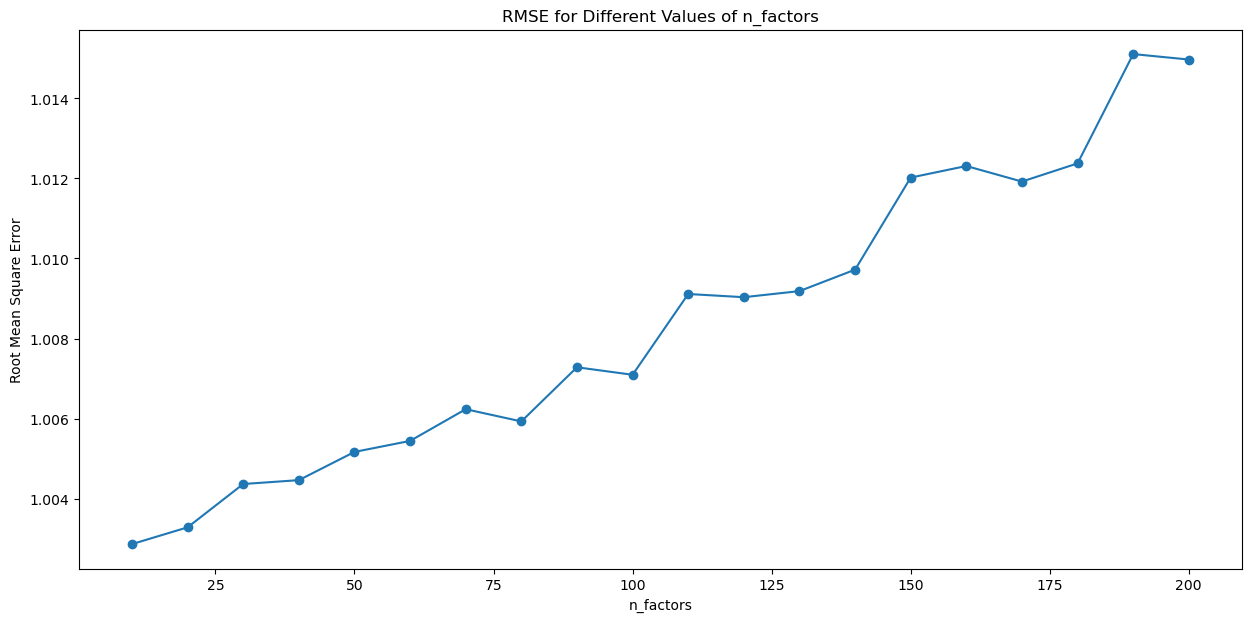

CPU times: user 9.92 s, sys: 390 ms, total: 10.3 s
Wall time: 9.6 s


[(10, 1.002864771038791),
 (20, 1.0032835590421436),
 (30, 1.0043654507338802),
 (40, 1.0044623293321204),
 (50, 1.0051671478280617),
 (60, 1.0054425846419113),
 (70, 1.0062345693158077),
 (80, 1.0059290471079532),
 (90, 1.0072820967426241),
 (100, 1.0070947125275858),
 (110, 1.0091126591566406),
 (120, 1.00903290379346),
 (130, 1.0091849615397506),
 (140, 1.0097209401205358),
 (150, 1.0120213585456073),
 (160, 1.0123103476271573),
 (170, 1.011921799611673),
 (180, 1.012375797479515),
 (190, 1.0151067649883518),
 (200, 1.0149703086102417)]

In [12]:
%%time
# Range of latent factors to test
factors = range(10, 201, 10)
# Calling function from earlier
test_svd_parameter(trainset, testset, 'n_factors', factors)

# Save as PNG
#plt.savefig('figures/RMSE-LatentFactors.png', bbox_inches='tight')

After running the model with a different number of latent factors it looks like increasing the number of factors leads to overfitting. Which happens when the model starts to learn not only the underlying patterns in the training data but also the noise. As a result, it performs well on the training data but poorly on the test data. It appears to perform better with a lower number of latent factors.

#### Epochs
Next I'll visualize the effect that the number of epochs has on RMSE score. The default was 20 

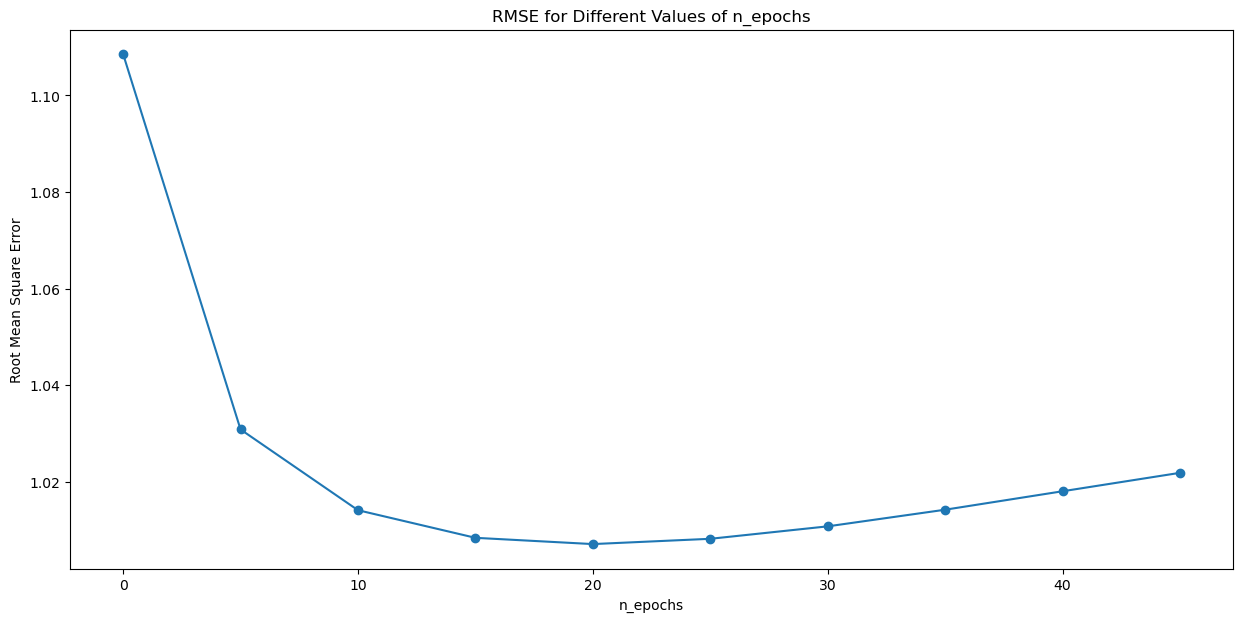

CPU times: user 5.38 s, sys: 35.5 ms, total: 5.42 s
Wall time: 5.37 s


[(0, 1.1085778006013718),
 (5, 1.0308338005721724),
 (10, 1.0141117261223995),
 (15, 1.0083928911232385),
 (20, 1.0070947125275858),
 (25, 1.0081888641285128),
 (30, 1.010766834050225),
 (35, 1.0142115901558952),
 (40, 1.0180332709978082),
 (45, 1.0218513166074672)]

In [13]:
%%time
# Range of epochs to test
epochs = range(0, 50, 5)
# Calling function from earlier
test_svd_parameter(trainset, testset, 'n_epochs', epochs)

# Save as PNG
#plt.savefig('figures/RMSE-NumberOfEpochs.png', bbox_inches='tight')

We can see that as the number of epochs increases, the RMSE quickly decreases, indicating an improvement in the model's prediction accuracy. After a certain number of epochs, the RMSE levels off, suggesting that further increasing the number of epochs doesn't significantly improve the model's performance. The optimal number of epochs appears to be around 20. 

#### Learning Rate
I also want to quickly visualize what effect the learning rate has on the RMSE score. The default learning rate for the parameter is 0.005.

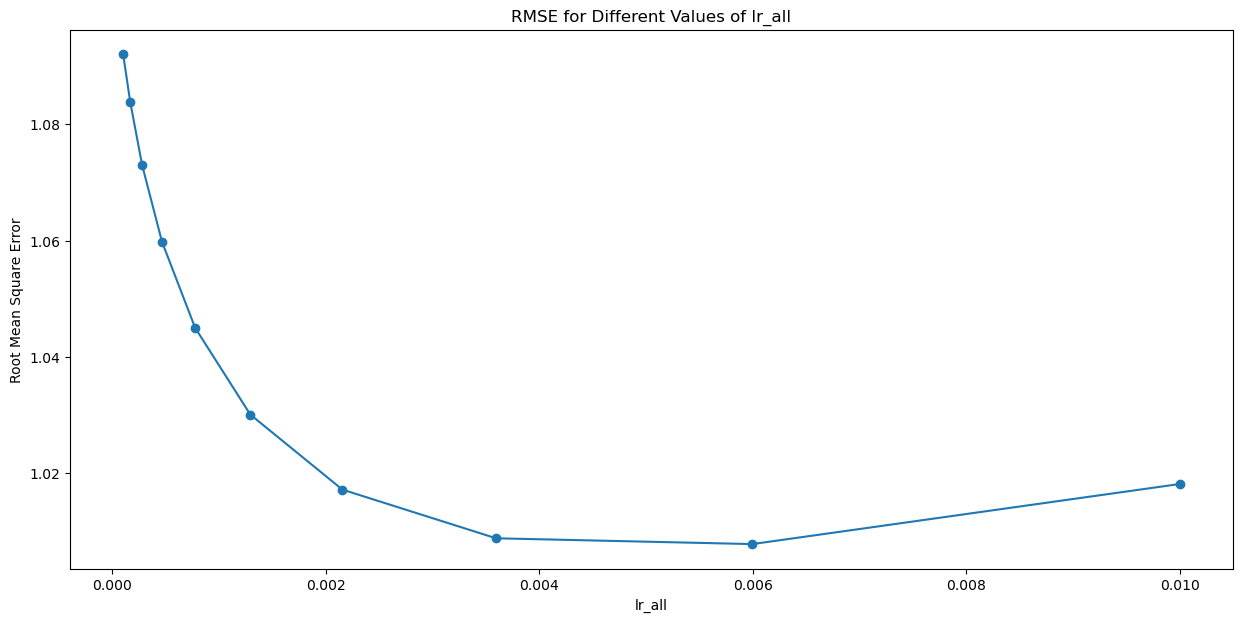

CPU times: user 7.83 s, sys: 36.2 ms, total: 7.87 s
Wall time: 7.75 s


[(0.0001, 1.0920484013316856),
 (0.0001668100537200059, 1.083794089490452),
 (0.0002782559402207126, 1.072963917112139),
 (0.00046415888336127773, 1.0597861644720452),
 (0.000774263682681127, 1.04501144524517),
 (0.001291549665014884, 1.030079376007964),
 (0.002154434690031882, 1.0171808631023758),
 (0.003593813663804626, 1.008817096952314),
 (0.005994842503189409, 1.0078198563103757),
 (0.01, 1.0181500054597201)]

In [10]:
%%time
# Range of learning rates to test
learning_rates = np.logspace(-4, -2, num=10)
# Calling function from earlier
test_svd_parameter(trainset, testset, 'lr_all', learning_rates)

# Save as PNG
#plt.savefig('figures/RMSE-LearningRates.png', bbox_inches='tight')

The chart shows how varying the learning rate impacts the RMSE of the model. The RMSE is initially very high, which suggests that the model isn’t learning enough each step to make significant progress towards minimizing the error. The RMSE then drops sharply, indicating that the model is starting to learn better and is making good progress in finding a lower error.

#### Regularization
I also want to quickly visualize what effect the regularization term has on the RMSE score. The default learning rate for the parameter is 0.02.

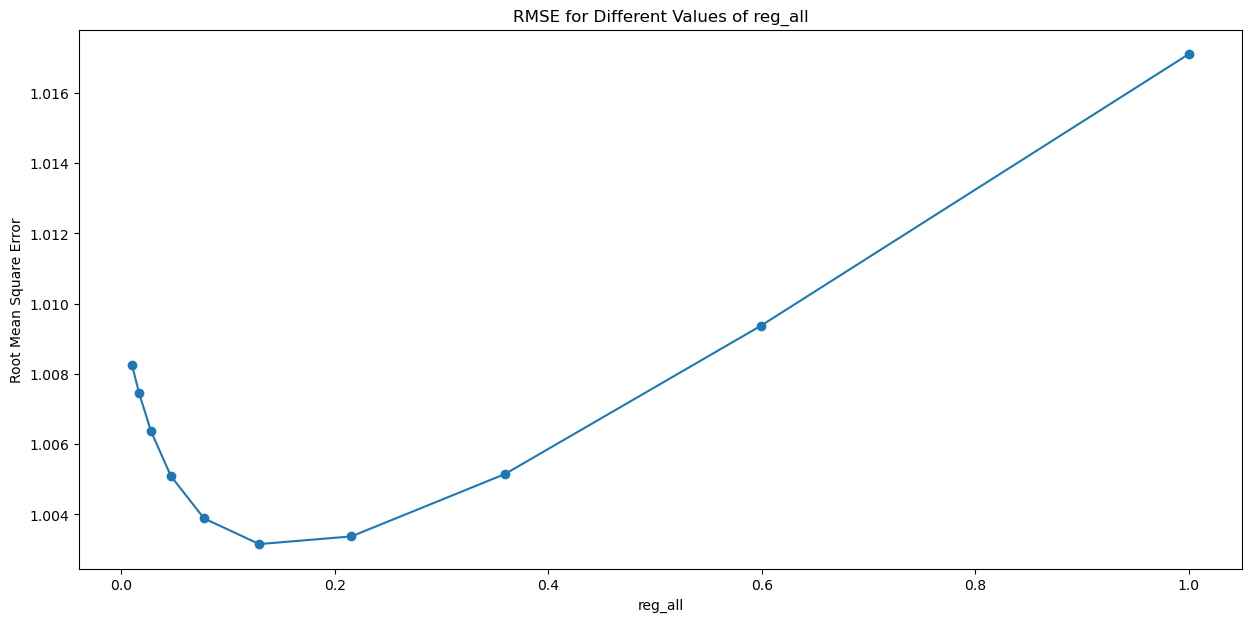

CPU times: user 4.9 s, sys: 25.8 ms, total: 4.92 s
Wall time: 4.84 s


[(0.01, 1.008256337523593),
 (0.016681005372000592, 1.007448678025267),
 (0.027825594022071243, 1.0063656843639215),
 (0.046415888336127774, 1.0050922478863566),
 (0.0774263682681127, 1.0038864235381886),
 (0.1291549665014884, 1.00315430676243),
 (0.21544346900318834, 1.00337235924162),
 (0.3593813663804626, 1.0051478852738231),
 (0.5994842503189409, 1.0093757382704496),
 (1.0, 1.017103268396892)]

In [14]:
%%time
# Range of the regularization term to test
reg_term = np.logspace(-2, 0, num=10)
# Calling function from earlier
test_svd_parameter(trainset, testset, 'reg_all', reg_term)

# Save as PNG
#plt.savefig('figures/RMSE-RegularizationTerm.png', bbox_inches='tight')

The plot shows RMSE scores as the regularization parameter reg_all increases. We can see the optimal regularization term to be around .2 and it's a slight imporvment over our baseline model. 

# Optimizing Paramters

We can use what we've learned above to narrow the values of our parameters of our grid search. 

In [15]:
%%time
# Defining grid of Funk SVD algorithm parameters to try:
param_grid = {
    'n_factors': [10, 15, 20, 25], # The number of factors to include
    'n_epochs': [15, 20, 25],     # The number of iterations of the SGD procedure
    'lr_all': [0.002, 0.005, 0.01], # The learning rate for all parameters
    'reg_all': [0.15, 0.2, .25]  # The regularization term for all parameters
}

# Setting up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(FunkSVD, param_grid, measures=['RMSE'], cv=5) # Use n_jobs=-1 if you have the processing power for it

# Performing the grid search on the data
grid_search.fit(data)

# best RMSE score
print(grid_search.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_search.best_params['rmse'])

0.987736725080332
{'n_factors': 15, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.15}
CPU times: user 2min 17s, sys: 233 ms, total: 2min 17s
Wall time: 2min 18s


Using grid search, we found the most optimal parameters for our algorithm that gave us a slightly improved RMSE score. We can now take these parameters and use them to generate predictions for our users.

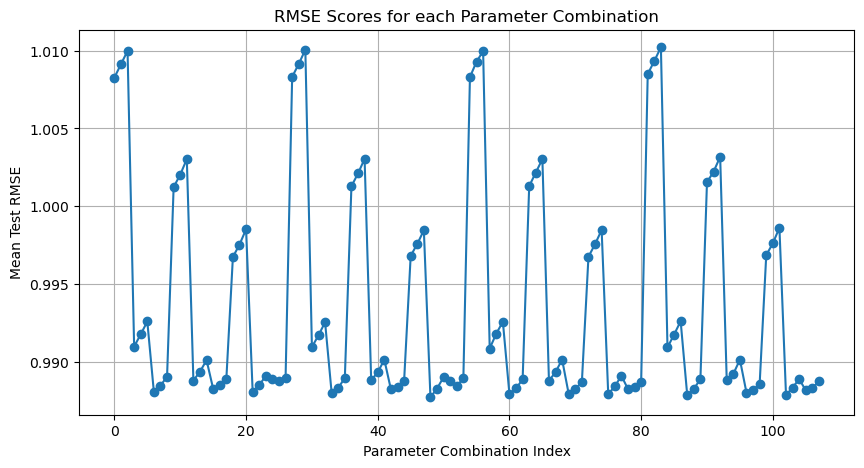

In [16]:
# Plotting the RMSE for all combinations of parameters
# Saving cv_results as a dictionary with keys as parameter combinations and values as the results
cv_results = grid_search.cv_results

# Converting the dictionary to a DataFrame for easier handling
results_df = pd.DataFrame.from_dict(cv_results)


# Plot the RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(results_df['mean_test_rmse'], marker='o')
plt.title('RMSE Scores for each Parameter Combination')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Test RMSE')
plt.grid(True)
plt.show()

The chart has a clear pattern to it. Looking into the results, it appears the parameter that has the greatest effect is the learning rate (LR). You can see there are three distinct steps in improvement for each learning rate parameter. The greater the lr, the better the RMSE score. 

# Final Model

In [17]:
%%time
# After finding the best parameters, we can now use them to train our Funk SVD model
algo = FunkSVD(n_factors=grid_search.best_params['rmse']['n_factors'],
                n_epochs=grid_search.best_params['rmse']['n_epochs'],
                lr_all=grid_search.best_params['rmse']['lr_all'],
                reg_all=grid_search.best_params['rmse']['reg_all'],
                random_state=25)

# Train the algorithm on all existing user ratings
trainset = data.build_full_trainset()
algo.fit(trainset)

# Now we need to predict ratings for all combinations of users and items that are NOT in the training set
testset = trainset.build_anti_testset()

# Predicting the ratings for the testset
predictions = algo.test(testset)

CPU times: user 46.6 s, sys: 1.04 s, total: 47.6 s
Wall time: 48 s
